In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/precog-assignment/fi.csv
/kaggle/input/precog-assignment/fi-2.csv
/kaggle/input/precog-assignment/judge_act_pre-2.csv
/kaggle/input/precog-assignment/final.csv
/kaggle/input/precog-assignment/state_time.png
/kaggle/input/precog-assignment/state_cases.png
/kaggle/input/precog-assignment/Judge_Act_merge.csv
/kaggle/input/precog-assignment/judges_clean/judges_clean.csv
/kaggle/input/precog-assignment/acts_sections/acts_sections.csv
/kaggle/input/precog-assignment/cases/cases_2015.csv
/kaggle/input/precog-assignment/cases/cases_2012.csv
/kaggle/input/precog-assignment/cases/cases_2018.csv
/kaggle/input/precog-assignment/cases/cases_2013.csv
/kaggle/input/precog-assignment/cases/cases_2017.csv
/kaggle/input/precog-assignment/cases/cases_2010.csv
/kaggle/input/precog-assignment/cases/cases_2014.csv
/kaggle/input/precog-assignment/cases/cases_2016.csv
/kaggle/input/precog-assignment/cases/cases_2011.csv
/kaggle/input/precog-assignment/keys/type_name_key.csv
/kaggle/input/precog-

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PowerTransformer

from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from yellowbrick.classifier import ROCAUC

import seaborn as sns
import matplotlib.pyplot as plt

# Data Pre-Processing
In this section, we perform the required Processing of our data in order to prepare it for our ML models.

In [4]:
data = pd.read_csv("../input/precog-assignment/final.csv",usecols=["criminal","state_code","female_judge","female_defendant","tenure","time_taken"])
data.head()

,criminal,state_code,female_judge,female_defendant,tenure,time_taken
0,0.0,13.0,0 nonfemale,0 male,43,200
1,0.0,13.0,0 nonfemale,0 male,138,421
2,1.0,7.0,0 nonfemale,0 male,621,869
3,1.0,7.0,0 nonfemale,0 male,1000,1174
4,1.0,7.0,0 nonfemale,0 male,441,578


In [5]:
num_attributes = ["time_taken"]
cat_attributes = ["criminal","state_code","female_judge","female_defendant"]

### Converting the categorical into 'category' dataype

In [6]:
data = data[(data["tenure"] > 0) & (data["time_taken"] > 0)] # removing spurious rows
for c in cat_attributes:
    data[c] = data[c].astype('category')

## Setting the threshold in order to label the data
In the following mini-section, we perform analysis in order to undertsand where to set the threshold of the tenure, in order to be able to split the
instances into 2 different categories

### Plotting a kde plot to understand the distribution of the 'tenure' column

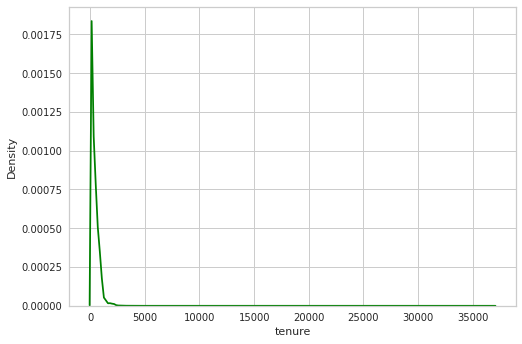

In [7]:
res = sns.kdeplot(data["tenure"],color='green')
plt.show()

In [8]:
data.describe()

,tenure,time_taken
count,3.115696e+06,3.115696e+06
mean,3.849675e+02,3.005516e+02
std,3.580247e+02,3.637689e+02
min,1.000000e+00,1.000000e+00
25%,1.230000e+02,2.600000e+01
50%,2.800000e+02,1.520000e+02
75%,5.600000e+02,4.510000e+02
max,3.702100e+04,3.652400e+04


### Here I am trying to remove the extreme values, so as to better normalise the data, and to ensure that these extreme values don't mess with the model

I am removing all the rows that have a tenure value of greater than 2000

In [9]:
# percentage of rows with tenure value greater than 2000
(data[data["tenure"] > 2000].shape[0] * 100)/data.shape[0] 

0.526142473463393

In [10]:
data = data[data["tenure"] < 2000]

### Plotting the distribution of the tenure column after removing the extreme values

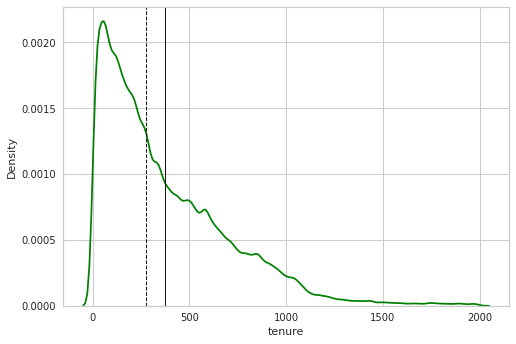

In [11]:
res = sns.kdeplot(data["tenure"],color='green')
plt.axvline(x=data.tenure.mean(), color='k',linestyle='-', linewidth=1) 
plt.axvline(x=data.tenure.median(), color='k',linestyle='--', linewidth=1) 
plt.show()

#### In the above plot the dotted vertical line represents the median value of the column and the smooth line represents the mean of the tenure column. From the above plot, it seems like the median more evenly splits the data, the below cell is used to confirm that

In [12]:
mean_ratio = (data[data["tenure"] > data.tenure.mean()].shape[0] * 100)/data.shape[0]
median_ratio = (data[data["tenure"] > data.tenure.median()].shape[0] * 100)/data.shape[0]

print("Percentage of instances greater than the mean: ",mean_ratio)
print("Percentage of instances greater than the median: ",median_ratio)

Percentage of instances greater than the mean:  39.514982560409386
Percentage of instances greater than the median:  49.903719262923204


#### From the above cell, we can see that the median almost perfectly divides the dataset, and thus it is more suitrable to be used as the threshold value to label the data

In [13]:
threshold = data["tenure"].median()
print(threshold)

278.0


#### Function to label the data

In [14]:
def label(tenure):
    if(tenure > threshold):
        return 1
    else:
        return 0

#### Forming the "target" column

##### **Here we define the classification problem**. 

The basis of the problem is to use the following features:time_taken,state_code,criminal,female_judge, and female_defendant, to somewhat **predict the experience\tenure of the judge**. 

More specifically, we try to predict whether the tenure of a judge is above or below a certain threshold, which we have defined to be the median of the tenure column.



In [15]:
data["target"] = data.apply(lambda x:label(x["tenure"]),axis = 1)
data.head()

,criminal,state_code,female_judge,female_defendant,tenure,time_taken,target
0,0.0,13.0,0 nonfemale,0 male,43,200,0
1,0.0,13.0,0 nonfemale,0 male,138,421,0
2,1.0,7.0,0 nonfemale,0 male,621,869,1
3,1.0,7.0,0 nonfemale,0 male,1000,1174,1
4,1.0,7.0,0 nonfemale,0 male,441,578,1


#### Final dataframe before column transformations

In [16]:
data = data[num_attributes + cat_attributes + ["target"]]
data.head()

,time_taken,criminal,state_code,female_judge,female_defendant,target
0,200,0.0,13.0,0 nonfemale,0 male,0
1,421,0.0,13.0,0 nonfemale,0 male,0
2,869,1.0,7.0,0 nonfemale,0 male,1
3,1174,1.0,7.0,0 nonfemale,0 male,1
4,578,1.0,7.0,0 nonfemale,0 male,1


## Analysis on the label splits

Below, analysis is done to understand the distribution of the labels, so as to ensure the test and train datasets have a similar distribution to ensure the model trained gets the best results

In [17]:
data['target'].value_counts()

0    1552619
1    1546651
Name: target, dtype: int64

<AxesSubplot:ylabel='target'>

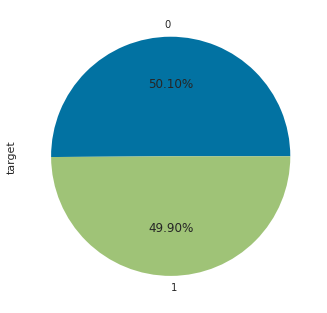

In [18]:
data['target'].value_counts().plot.pie(autopct = '%1.2f%%')

In [19]:
y = data.pop('target') #Target
X = data  #DataFrame with features

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=10)
print(y_train.value_counts())
print(y_test.value_counts())

0    1163853
1    1160599
Name: target, dtype: int64
0    388766
1    386052
Name: target, dtype: int64


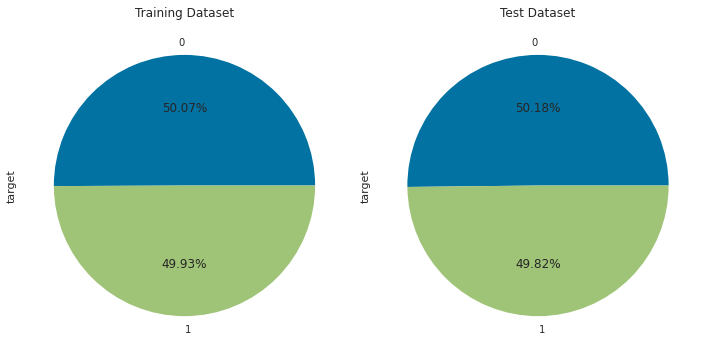

In [20]:
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
y_train.value_counts().plot.pie(autopct = '%1.2f%%')
plt.title('Training Dataset')

plt.subplot(1,2,2)
y_test.value_counts().plot.pie(autopct = '%1.2f%%')
plt.title('Test Dataset')

plt.tight_layout()

### Label distribution analysis results

Here we can see that by using the `train_test_split` method from the sklearn library the distribution of the labels in both the train and the test dataset are similar to each other and the to the distribution of labels in the overall dataset. 

If this was not the case we have had to use alternate methods to get the train-test split, such as the `StratifiedShuffleSplit` method from Sklearn, that ensures that the distribution of labels is maintained

### Data Transformations

Before providing our dataset to the ML models, we have to make certain transformations to the data. We first OneHotEncode the categorical data, as the ML model works with numbers and cannot work with categorical values. 

Next, we perform the `PowerTransformer` method the numerical attributes in order to make the numerical values more gaussian like

In [21]:
X_train = pd.get_dummies(X_train) ## OneHotEncoding
for c in num_attributes:
    pt = PowerTransformer()
    X_train.loc[:, c] = pt.fit_transform(np.array(X_train[c]).reshape(-1, 1))

In [22]:
X_train.head()

,time_taken,criminal_0.0,criminal_1.0,state_code_1.0,state_code_2.0,state_code_3.0,state_code_4.0,state_code_5.0,state_code_6.0,state_code_7.0,...,state_code_24.0,state_code_25.0,state_code_26.0,state_code_27.0,state_code_29.0,state_code_30.0,female_judge_0 nonfemale,female_judge_1 female,female_defendant_0 male,female_defendant_1 female
2731210,1.947131,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
273090,1.435107,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2859216,-0.270707,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2827865,0.531463,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
347485,-0.863891,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [23]:
y_train.head()

2731210    1
273090     0
2859216    1
2827865    1
347485     0
Name: target, dtype: int64

# Training Model

### Models that are to be trained

In [24]:
sgd_c = SGDClassifier(random_state=42)
rf_c = RandomForestClassifier()
mlp_c = MLPClassifier(random_state=1,max_iter=500)

#### Performing the required transformations on the test data

In [25]:
X_test = pd.get_dummies(X_test)
for c in num_attributes:
    pt = PowerTransformer()
    X_test.loc[:, c] = pt.fit_transform(np.array(X_test[c]).reshape(-1, 1))

### Function to train the model, fit it with the training data and then measure its performance on the test data, and plot the corresponding ROC curve

When checking the performance of classification models on datasets with a class imbalance,i.e with the no of each class being unequal (check above for the label distribution analysis), accuracy can be a misleading metric. 

One of the ways to measure of the performance of the model in such cases, is by plotting an ROC Curve. It plots True Positive Rate vs False Positive Rate. The area under the curve will gove us how much the model is able to distinuguish between the positive and the negative class for each label.

This information gives us a better measure for the performance of the model.

We also plot the cofusion matrix produced by both models and also give the classification report for each model

In [26]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    visualizer = ROCAUC(model, binary=True)
                                                                         
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

# Peformance Measure for the SGD Classifier

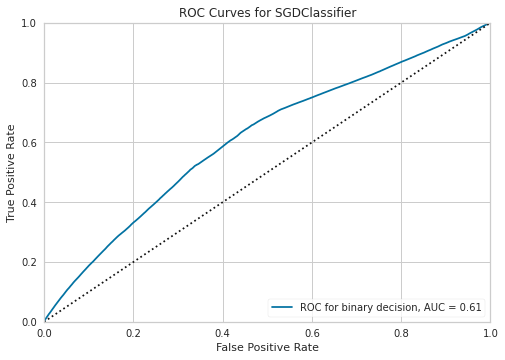

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for SGDClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=True, estimator=SGDClassifier(random_state=42), macro=False,
       micro=False, per_class=False)

In [27]:
plot_ROC_curve(sgd_c,X_train,y_train,X_test,y_test)

In [28]:
sgd_c.fit(X_train,y_train)
pred_o = sgd_c.predict(X_test)

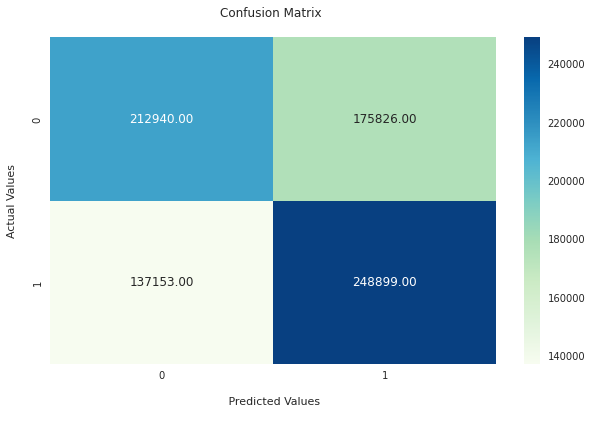

In [29]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,pred_o), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['0','1'])
fx.yaxis.set_ticklabels(['0','1'])
plt.show()

In [30]:
print(classification_report(y_test, pred_o))

              precision    recall  f1-score   support

           0       0.61      0.55      0.58    388766
           1       0.59      0.64      0.61    386052

    accuracy                           0.60    774818
   macro avg       0.60      0.60      0.60    774818
weighted avg       0.60      0.60      0.60    774818



### Performance Measure Analysis


# Peformance Measure for the Random Forest Classifier

### Performance Measure Analysis

From the above analysis, we can see that once again the model does learn, and is able to diffrentiate between the 2 classes at some level.

**ROC Curve**: The AUC of 0.61 tells us thate the model can diffrentiate 62% of the positive and negative instances. This shows us that the there is some overlap between the psotive and negative classes

**Classfication report**: The classifiaction report shows us that the model is being able to learn from the data as the precision and recall scores for both classes are quite decent

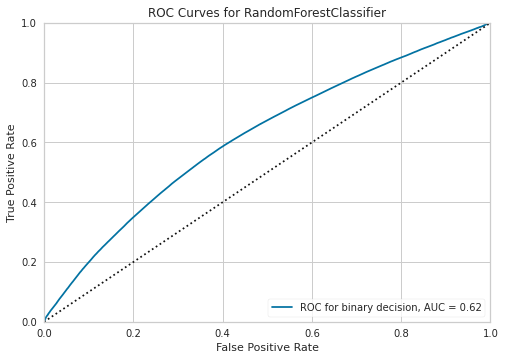

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=True, estimator=RandomForestClassifier(), macro=False,
       micro=False, per_class=False)

In [31]:
plot_ROC_curve(rf_c,X_train,y_train,X_test,y_test)

In [32]:
rf_c.fit(X_train,y_train)
pred_r = rf_c.predict(X_test)

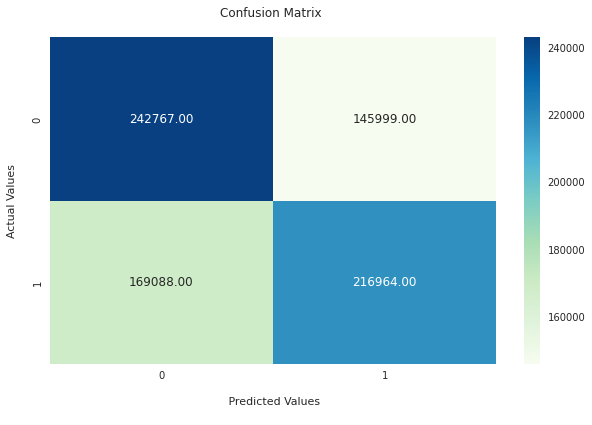

In [33]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,pred_r), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['0','1'])
fx.yaxis.set_ticklabels(['0','1'])
plt.show()

In [34]:
print(classification_report(y_test, pred_r))

              precision    recall  f1-score   support

           0       0.59      0.62      0.61    388766
           1       0.60      0.56      0.58    386052

    accuracy                           0.59    774818
   macro avg       0.59      0.59      0.59    774818
weighted avg       0.59      0.59      0.59    774818



### Performance Measure Analysis

From the above analysis, we can see that once again the model does learn, and is able to diffrentiate between the 2 classes at some level.

**ROC Curve**: The AUC of 0.62 tells us thate the model can diffrentiate 62% of the positive and negative instances. This shows us that the there is some overlap between the psotive and negative classes

**Classfication report**: The classifiaction report shows us that the model is being able to learn from the data as the precision and recall scores for both classes are quite decent

# Peformance Measure for the Muiti Layer Perceptron Classifier

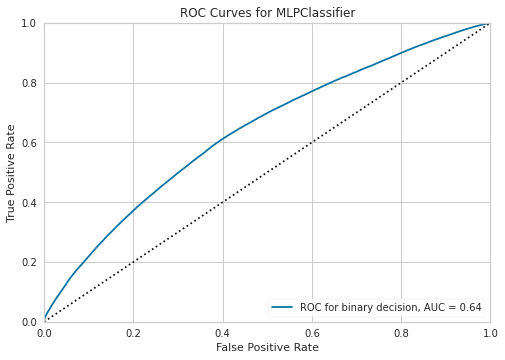

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       binary=True, estimator=MLPClassifier(max_iter=500, random_state=1),
       macro=False, micro=False, per_class=False)

In [35]:
plot_ROC_curve(mlp_c,X_train,y_train,X_test,y_test)

In [36]:
mlp_c.fit(X_train,y_train)
pred_m = mlp_c.predict(X_test)

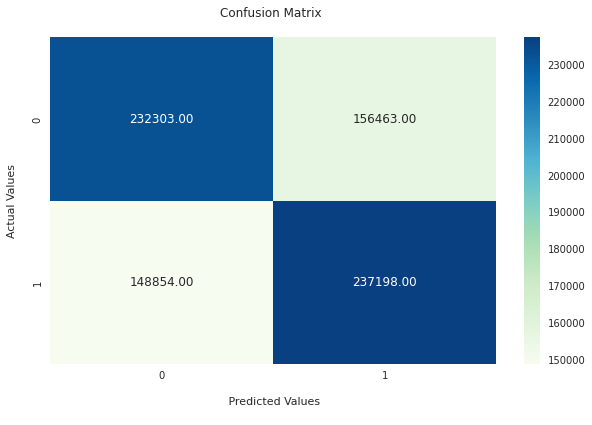

In [37]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,pred_m), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['0','1'])
fx.yaxis.set_ticklabels(['0','1'])
plt.show()

In [38]:
print(classification_report(y_test, pred_m))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60    388766
           1       0.60      0.61      0.61    386052

    accuracy                           0.61    774818
   macro avg       0.61      0.61      0.61    774818
weighted avg       0.61      0.61      0.61    774818



### Performance Measure Analysis

From the above analysis, we can see that once again the model does learn, and is able to diffrentiate between the 2 classes at some level. The analysis of this is similar to the Random Forest Classifier

**ROC Curve**: The AUC of 0.64 tells us thate the model can diffrentiate 62% of the positive and negative instances. This shows us that the there is some overlap between the positive and negative classes

**Classfication report**: The classifiaction report shows us that the model is being able to learn from the data as the precision and recall scores for both classes are quite decent

The MLP classifier seems to slightly edge out the other 2 classifiers, in both accuracy and in the other classification metrics

# Insights 
From this classification problem, we can gleam the following insights:

**1. From the analysis of the metrics for each model, we can see that there is a decent correlation between the features used and the tenure of the judge.**

**2. The performance of the model however, does leave a lot to be desired, and thus more relevant features would be required to train more accurate models**

**3. The correlation of the feature does confirm analysis done in the Analysis section of the project, especially the Analysis done in the Analysis-4 notebook**